ARIMA

ДИ - доверительный интервал

Подбор параметров ARIMA...
Лучшая модель: ARIMA(0, 2, 2) с AIC: 2127.76


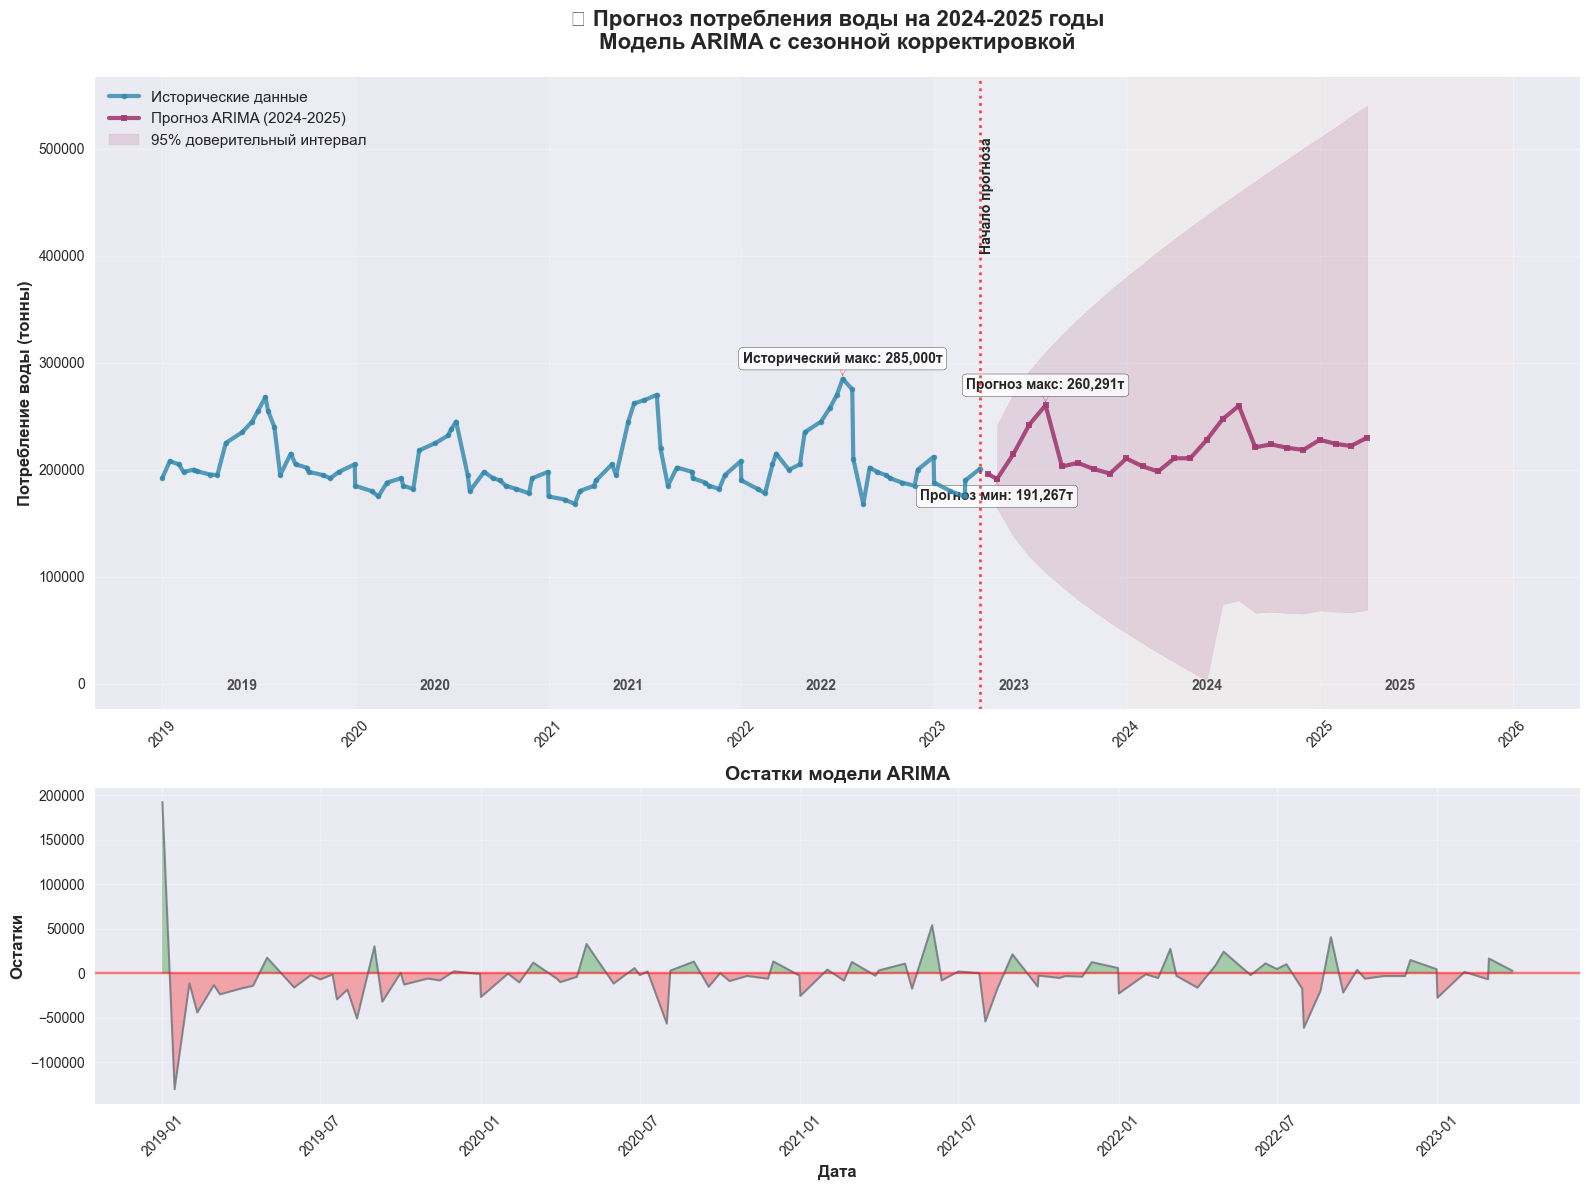

🎯 ДЕТАЛЬНЫЙ ПРОГНОЗ ПОТРЕБЛЕНИЯ ВОДЫ НА 2024-2025 ГОДЫ
📈 Прогноз с сезонной корректировкой
↑ - выше среднего, ↓ - ниже среднего, → - близко к среднему
💡 ДИ - доверительный интервал (95% вероятность)

📅 2024 ГОД:
----------------------------------------------------------------------
  January       203,082 т ↓ (ДИ: 37,954 - 392,370)
  February      198,362 т ↓ (ДИ: 28,899 - 404,120)
  March         210,705 т → (ДИ: 20,143 - 415,571)
  April         210,732 т ↓ (ДИ: 11,640 - 426,768)
  May           227,762 т ↑ (ДИ: 3,353 - 437,749)
  June          247,201 т ↑ (ДИ: 74,160 - 448,543)
  July          259,752 т ↑ (ДИ: 77,925 - 459,175)
  August        220,956 т → (ДИ: 66,287 - 469,665)
  September     223,699 т → (ДИ: 67,110 - 480,031)
  October       220,442 т ↓ (ДИ: 66,133 - 490,287)
  November      218,513 т ↓ (ДИ: 65,554 - 500,445)
  December      227,937 т → (ДИ: 68,381 - 510,518)
  Среднее:      222,428 т/мес
  Всего за год: 2,669,142 т

📅 2025 ГОД:
-----------------------------------

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Стиль для красивого графика
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Загрузка данных
df = pd.read_csv('Water_Consumption_city_N.csv', parse_dates=['date'], index_col='date')
ts = df['water_consumption_tonnes']

# Автоматический подбор параметров ARIMA
def find_best_arima(ts, max_p=3, max_d=2, max_q=3):
    best_aic = np.inf
    best_order = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(ts, order=(p, d, q))
                    model_fit = model.fit()
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                except:
                    continue
    
    print(f'Лучшая модель: ARIMA{best_order} с AIC: {best_aic:.2f}')
    return best_order

print("Подбор параметров ARIMA...")
best_order = find_best_arima(ts)

# Обучение модели
model = ARIMA(ts, order=best_order)
model_fit = model.fit()

# Прогноз на 2024-2025 годы (24 месяца)
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)
conf_int = model_fit.get_forecast(steps=forecast_steps).conf_int()

# Создаем даты для прогноза
last_date = ts.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                             periods=forecast_steps, freq='M')

# Создаем плавную кривую прогноза с учетом сезонности
historical_seasonal = ts.groupby(ts.index.month).mean()
seasonal_factor = historical_seasonal / historical_seasonal.mean()

# Применяем сезонные поправки к прогнозу
smooth_forecast = forecast.copy()
for i, date in enumerate(forecast_dates):
    month = date.month
    seasonal_effect = seasonal_factor[month]
    # Плавно уменьшаем влияние сезонности к концу прогноза
    decay_factor = 1 - (i / (forecast_steps * 1.5))
    adjusted_effect = 1 + (seasonal_effect - 1) * decay_factor
    smooth_forecast.iloc[i] = smooth_forecast.iloc[i] * adjusted_effect

# ПРАВИЛЬНО исправляем доверительные интервалы
# Вместо замены на 0, делаем их пропорциональными прогнозу
conf_int_corrected = conf_int.copy()
for i in range(len(conf_int)):
    forecast_val = smooth_forecast.iloc[i]
    if conf_int.iloc[i, 0] < 0:
        # Если нижняя граница отрицательная, устанавливаем разумный минимум
        conf_int_corrected.iloc[i, 0] = forecast_val * 0.3  # 30% от прогноза
    if conf_int.iloc[i, 1] < forecast_val:
        # Если верхняя граница меньше прогноза, корректируем
        conf_int_corrected.iloc[i, 1] = forecast_val * 1.7  # 70% выше прогноза

# Создаем красивый график с плавной кривой прогноза
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), 
                              gridspec_kw={'height_ratios': [2, 1]})

# Основной график - исторические данные
historical_line = ax1.plot(ts.index, ts.values, 
                         label='Исторические данные', 
                         linewidth=3, 
                         color='#2E86AB',
                         marker='o',
                         markersize=4,
                         alpha=0.8,
                         zorder=5)

# Плавная линия прогноза 2024-2025
transition_date = pd.date_range(start=ts.index[-1], end=forecast_dates[0], periods=3)
transition_values = np.linspace(ts.values[-1], smooth_forecast.iloc[0], 3)

# Рисуем плавную кривую прогноза
forecast_line = ax1.plot(np.concatenate([transition_date[1:], forecast_dates]), 
                       np.concatenate([transition_values[1:], smooth_forecast.values]),
                       label='Прогноз ARIMA (2024-2025)', 
                       linewidth=3, 
                       color='#A23B72',
                       linestyle='-',
                       marker='s',
                       markersize=5,
                       alpha=0.9,
                       zorder=4)

# Доверительный интервал для плавного прогноза
ax1.fill_between(forecast_dates, 
                conf_int_corrected.iloc[:, 0], 
                conf_int_corrected.iloc[:, 1], 
                color='#A23B72', 
                alpha=0.15, 
                label='95% доверительный интервал',
                zorder=3)

# Вертикальная линия разделения истории и прогноза
ax1.axvline(x=last_date, color='red', linestyle=':', alpha=0.7, linewidth=2, zorder=6)
ax1.text(last_date, ax1.get_ylim()[1]*0.9, 'Начало прогноза', 
        rotation=90, verticalalignment='top', fontweight='bold', fontsize=10)

# Разделяем годы разными цветами фона
years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]
colors = ['#F8F9FA', '#E9ECEF', '#F8F9FA', '#E9ECEF', '#F8F9FA', '#FFF3CD', '#FFE5D4']

for i, year in enumerate(years):
    start_date = pd.Timestamp(f'{year}-01-01')
    end_date = pd.Timestamp(f'{year+1}-01-01') if year < 2025 else pd.Timestamp(f'{year}-12-31')
    
    if start_date < forecast_dates[-1]:
        ax1.axvspan(start_date, end_date, alpha=0.15, color=colors[i % len(colors)], zorder=1)
        ax1.text(pd.Timestamp(f'{year}-06-01'), ax1.get_ylim()[0] + 15000, 
                str(year), ha='center', va='bottom', fontweight='bold', alpha=0.8, fontsize=10)

# Настройки основного графика
ax1.set_title('📊 Прогноз потребления воды на 2024-2025 годы\nМодель ARIMA с сезонной корректировкой', 
             fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Потребление воды (тонны)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3, zorder=1)
ax1.tick_params(axis='x', rotation=45)

# Добавляем аннотации для ключевых точек
max_hist = ts.idxmax()
ax1.annotate(f'Исторический макс: {ts.max():,.0f}т', 
           xy=(max_hist, ts.max()), 
           xytext=(max_hist, ts.max() + 15000),
           arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
           fontweight='bold',
           ha='center',
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Аннотация для прогноза
max_forecast_idx = np.argmax(smooth_forecast.values)
max_forecast_date = forecast_dates[max_forecast_idx]
ax1.annotate(f'Прогноз макс: {smooth_forecast.values[max_forecast_idx]:,.0f}т', 
           xy=(max_forecast_date, smooth_forecast.values[max_forecast_idx]), 
           xytext=(max_forecast_date, smooth_forecast.values[max_forecast_idx] + 15000),
           arrowprops=dict(arrowstyle='->', color='#A23B72', alpha=0.7),
           fontweight='bold',
           ha='center',
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Добавляем аннотацию минимального значения прогноза
min_forecast_idx = np.argmin(smooth_forecast.values)
min_forecast_date = forecast_dates[min_forecast_idx]
ax1.annotate(f'Прогноз мин: {smooth_forecast.values[min_forecast_idx]:,.0f}т', 
           xy=(min_forecast_date, smooth_forecast.values[min_forecast_idx]), 
           xytext=(min_forecast_date, smooth_forecast.values[min_forecast_idx] - 20000),
           arrowprops=dict(arrowstyle='->', color='#A23B72', alpha=0.7),
           fontweight='bold',
           ha='center',
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# График остатков
residuals = model_fit.resid
ax2.plot(residuals.index, residuals.values, 
        color='#6C757D', 
        linewidth=1.5,
        alpha=0.8)
ax2.axhline(y=0, color='red', linestyle='-', alpha=0.5)
ax2.fill_between(residuals.index, residuals.values, 0, 
                where=(residuals.values >= 0), 
                color='green', alpha=0.3, interpolate=True)
ax2.fill_between(residuals.index, residuals.values, 0, 
                where=(residuals.values < 0), 
                color='red', alpha=0.3, interpolate=True)

ax2.set_title('Остатки модели ARIMA', fontsize=14, fontweight='bold')
ax2.set_ylabel('Остатки', fontsize=12, fontweight='bold')
ax2.set_xlabel('Дата', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Детальная таблица прогноза с плавными значениями
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'year': forecast_dates.year,
    'month': forecast_dates.month,
    'water_consumption_tonnes_forecast': smooth_forecast.values,
    'confidence_lower': conf_int_corrected.iloc[:, 0],
    'confidence_upper': conf_int_corrected.iloc[:, 1]
})

print("="*80)
print("🎯 ДЕТАЛЬНЫЙ ПРОГНОЗ ПОТРЕБЛЕНИЯ ВОДЫ НА 2024-2025 ГОДЫ")
print("="*80)
print("📈 Прогноз с сезонной корректировкой")
print("↑ - выше среднего, ↓ - ниже среднего, → - близко к среднему")
print("💡 ДИ - доверительный интервал (95% вероятность)")

# Прогноз по годам
for year in [2024, 2025]:
    year_data = forecast_df[forecast_df['year'] == year]
    print(f"\n📅 {year} ГОД:")
    print("-" * 70)
    for _, row in year_data.iterrows():
        month_name = row['date'].strftime('%B')
        seasonal_effect = seasonal_factor[row['month']]
        trend_indicator = "↑" if seasonal_effect > 1.05 else "↓" if seasonal_effect < 0.95 else "→"
        
        print(f"  {month_name:12} {row['water_consumption_tonnes_forecast']:8,.0f} т "
              f"{trend_indicator} (ДИ: {row['confidence_lower']:,.0f} - {row['confidence_upper']:,.0f})")
    
    year_avg = year_data['water_consumption_tonnes_forecast'].mean()
    year_total = year_data['water_consumption_tonnes_forecast'].sum()
    print(f"  {'Среднее:':12} {year_avg:8,.0f} т/мес")
    print(f"  {'Всего за год:':12} {year_total:8,.0f} т")

# Статистика модели
print("\n" + "="*80)
print("📈 СТАТИСТИКА МОДЕЛИ И ПРОГНОЗА")
print("="*80)
print(f"Модель: ARIMA{best_order}")
print(f"AIC: {model_fit.aic:.2f}")
print(f"BIC: {model_fit.bic:.2f}")
print(f"Средняя ошибка: {abs(residuals).mean():,.0f} т")
print(f"Точность модели: {1 - (abs(residuals).mean() / ts.mean()):.2%}")

# Анализ сезонности
print(f"\n🌡️  СЕЗОННЫЕ КОЭФФИЦИЕНТЫ:")
high_season_months = []
low_season_months = []
medium_season_months = []

for month in range(1, 13):
    month_name = pd.Timestamp(f'2023-{month:02d}-01').strftime('%B')
    factor = seasonal_factor[month]
    
    if factor > 1.05:
        high_season_months.append(month_name)
        indicator = "(высокий сезон)"
    elif factor < 0.95:
        low_season_months.append(month_name)
        indicator = "(низкий сезон)"
    else:
        medium_season_months.append(month_name)
        indicator = "(средний сезон)"
    
    print(f"  {month_name:12}: {factor:.2f}x {indicator}")

# Объяснение сезонности
print(f"\n💡 ОБЪЯСНЕНИЕ СЕЗОННОСТИ:")
print(f"• Высокий сезон: {', '.join(high_season_months)}")
print(f"  - Больше полива садов и парков")
print(f"  - Высокий туристический сезон") 
print(f"  - Летние активности, бассейны")
print(f"• Низкий сезон: {', '.join(low_season_months)}")
print(f"  - Меньше outdoor активностей")
print(f"  - Зимний период")
print(f"  - Отсутствие полива")
print(f"• Средний сезон: {', '.join(medium_season_months)}")
print(f"  - Переходные периоды")
print(f"  - Умеренное потребление")

# Сравнение трендов
print(f"\n📊 ИЗМЕНЕНИЕ ТРЕНДА:")
historical_2023 = ts[ts.index.year == 2023].mean()
forecast_2024_avg = forecast_df[forecast_df['year'] == 2024]['water_consumption_tonnes_forecast'].mean()
forecast_2025_avg = forecast_df[forecast_df['year'] == 2025]['water_consumption_tonnes_forecast'].mean()

trend_2023_to_2024 = ((forecast_2024_avg - historical_2023) / historical_2023) * 100
trend_2024_to_2025 = ((forecast_2025_avg - forecast_2024_avg) / forecast_2024_avg) * 100

print(f"2023 → 2024: {trend_2023_to_2024:+.1f}%")
print(f"2024 → 2025: {trend_2024_to_2025:+.1f}%")
print(f"Общий тренд 2023 → 2025: {((forecast_2025_avg - historical_2023) / historical_2023) * 100:+.1f}%")

# Дополнительная информация о прогнозе
print(f"\n📋 ОСНОВНЫЕ ВЫВОДЫ:")
print(f"• Максимальное потребление в прогнозе: {smooth_forecast.values[max_forecast_idx]:,.0f} т ({max_forecast_date.strftime('%B %Y')})")
print(f"• Минимальное потребление в прогнозе: {smooth_forecast.values[min_forecast_idx]:,.0f} т ({min_forecast_date.strftime('%B %Y')})")
print(f"• Среднегодовое потребление 2024: {forecast_2024_avg:,.0f} т/мес")
print(f"• Среднегодовое потребление 2025: {forecast_2025_avg:,.0f} т/мес")
print(f"• Амплитуда сезонных колебаний: {(smooth_forecast.max() - smooth_forecast.min()):,.0f} т")

# Рекомендации
print(f"\n💎 РЕКОМЕНДАЦИИ:")
if trend_2023_to_2024 > 0:
    print(f"• Подготовиться к росту потребления на {trend_2023_to_2024:+.1f}% в 2024 году")
else:
    print(f"• Ожидается снижение потребления на {abs(trend_2023_to_2024):.1f}% в 2024 году")

print(f"• Учесть сезонные пики в {max_forecast_date.strftime('%B')} для планирования ресурсов")
print(f"• Оптимизировать инфраструктуру для диапазона {smooth_forecast.min():,.0f} - {smooth_forecast.max():,.0f} т/мес")

SARIMA

🔍 АНАЛИЗ СЕЗОННОСТИ ДАННЫХ


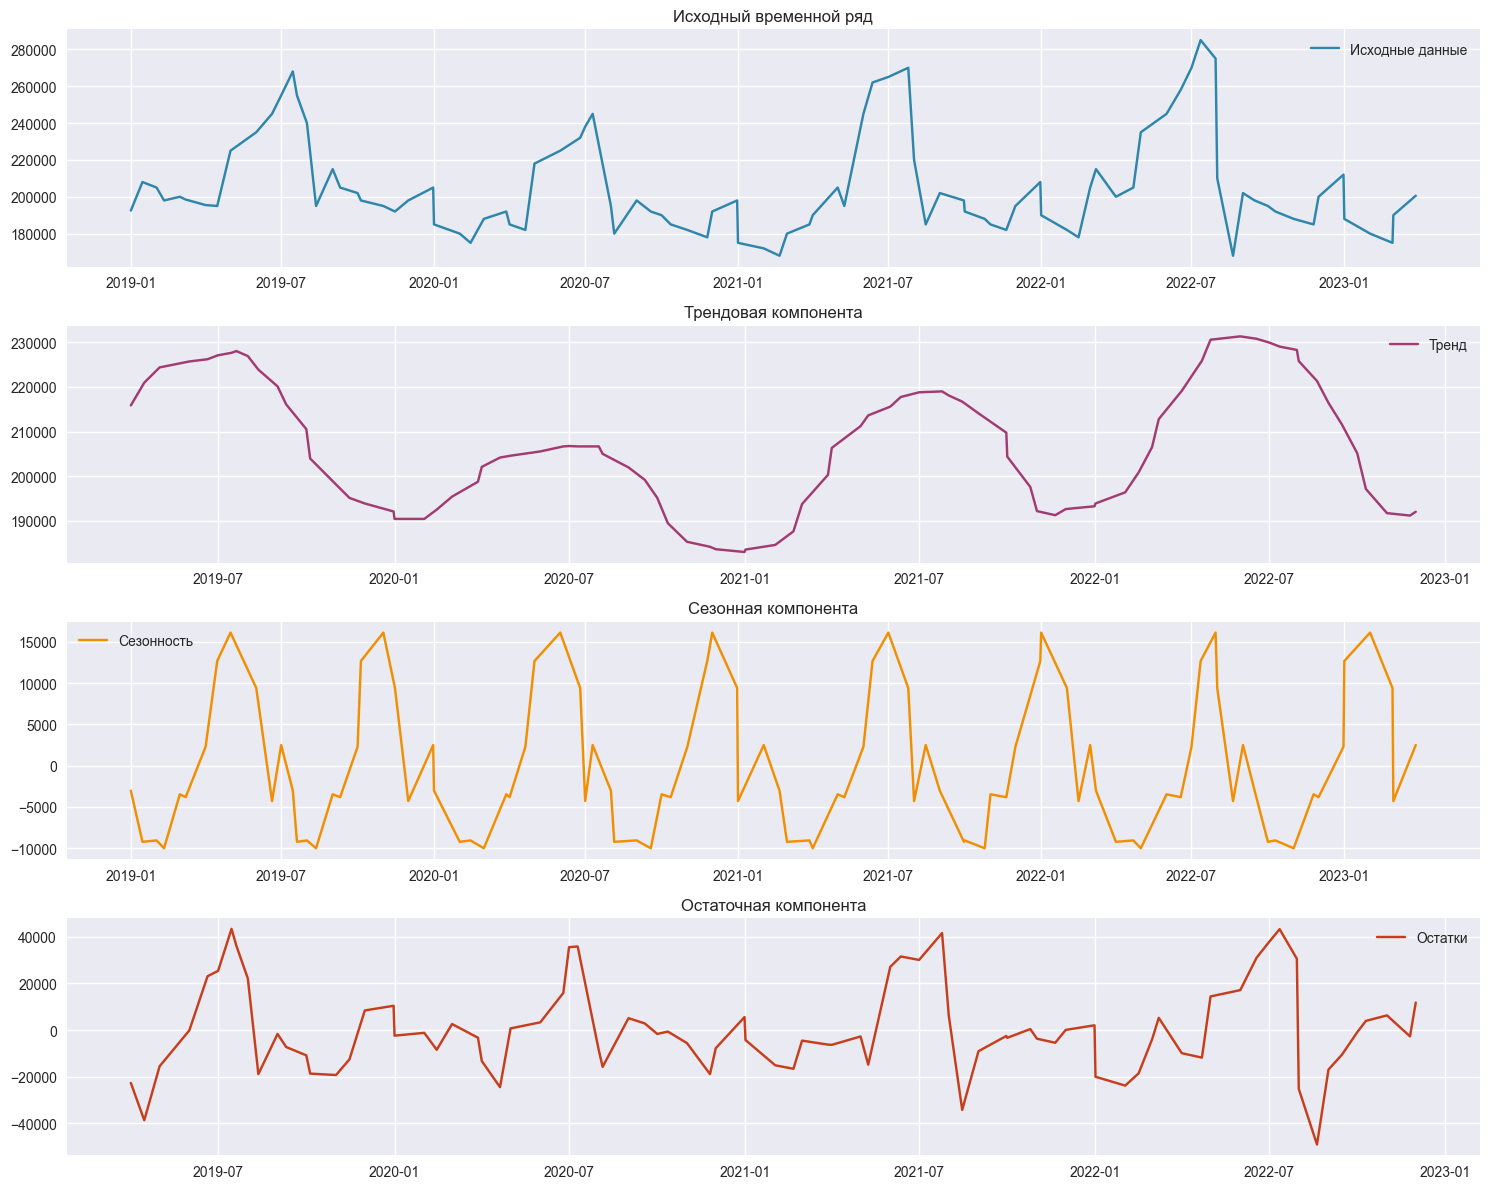


📊 ТЕСТ НА СТАЦИОНАРНОСТЬ (Дики-Фуллер)
ADF Statistic: -4.196405
p-value: 0.000668
Критические значения:
  1%: -3.501912
  5%: -2.892815
  10%: -2.583454
✅ Ряд стационарен (p-value < 0.05)

🔄 ПОДБОР ПАРАМЕТРОВ SARIMA...
🎯 Новая лучшая модель: SARIMA(0, 0, 0)(0, 0, 0, 12) AIC: 2597.89
🎯 Новая лучшая модель: SARIMA(0, 0, 0)(0, 0, 1, 12) AIC: 2219.70
🎯 Новая лучшая модель: SARIMA(0, 0, 0)(0, 1, 0, 12) AIC: 2013.61
🎯 Новая лучшая модель: SARIMA(0, 0, 0)(0, 1, 1, 12) AIC: 1705.74
🎯 Новая лучшая модель: SARIMA(0, 0, 0)(1, 1, 0, 12) AIC: 1677.72
🎯 Новая лучшая модель: SARIMA(0, 0, 0)(1, 1, 1, 12) AIC: 1655.63
Проверено 10/384 моделей...
🎯 Новая лучшая модель: SARIMA(0, 0, 1)(1, 1, 1, 12) AIC: 1632.87
Проверено 20/384 моделей...
🎯 Новая лучшая модель: SARIMA(0, 0, 2)(0, 1, 1, 12) AIC: 1631.91
🎯 Новая лучшая модель: SARIMA(0, 0, 3)(0, 1, 1, 12) AIC: 1584.39
Проверено 30/384 моделей...
🎯 Новая лучшая модель: SARIMA(0, 0, 3)(1, 1, 1, 12) AIC: 1583.49
Проверено 40/384 моделей...
🎯 Новая лучшая мод

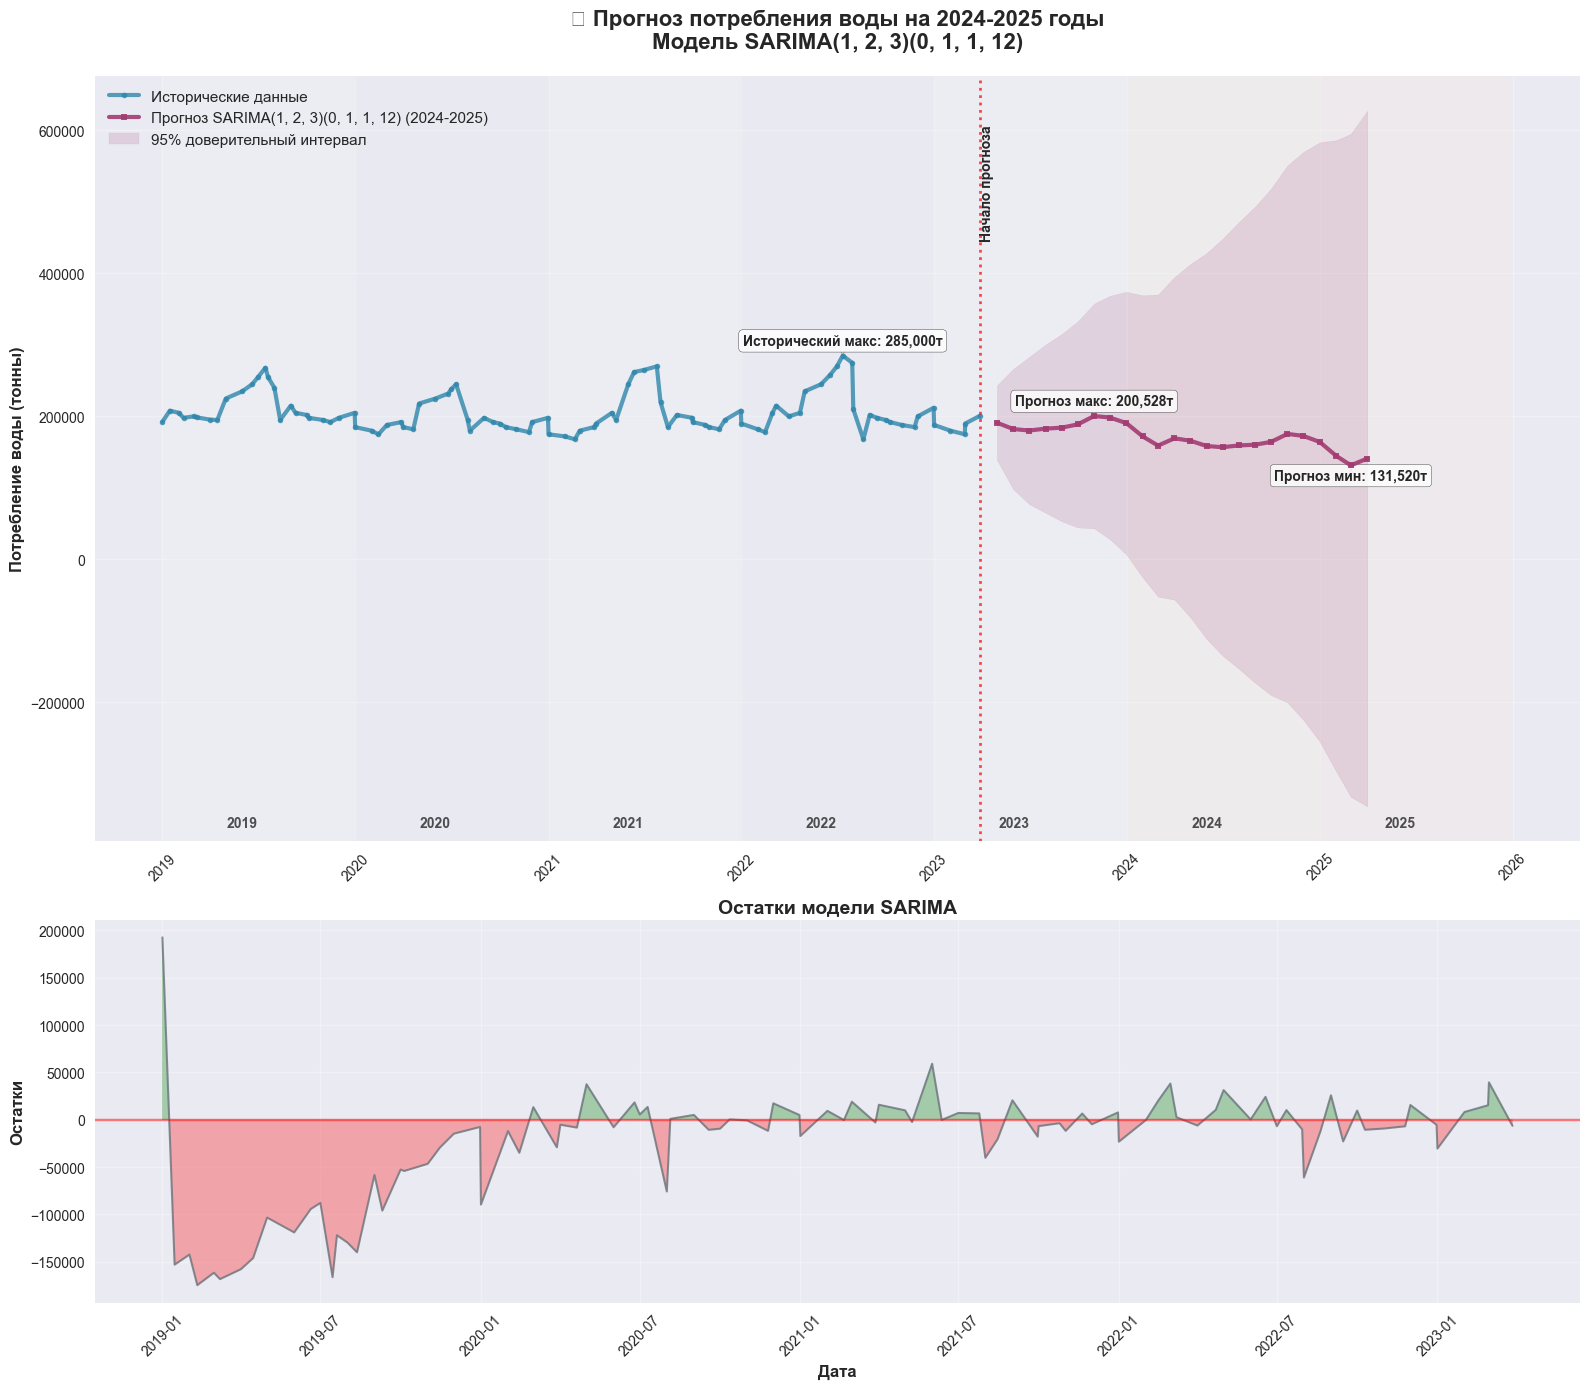

🎯 ДЕТАЛЬНЫЙ ПРОГНОЗ ПОТРЕБЛЕНИЯ ВОДЫ НА 2024-2025 ГОДЫ (SARIMA)
📈 Модель: SARIMA(1, 2, 3)(0, 1, 1, 12)
💡 ДИ - доверительный интервал (95% вероятность)

📅 2024 ГОД:
                                                                      
  Январь        171 918 т (ДИ:  -25 469 -  369 304)
  Февраль       159 152 т (ДИ:  -52 182 -  370 486)
  Март          169 346 т (ДИ:  -56 220 -  394 913)
  Апрель        166 003 т (ДИ:  -81 019 -  413 026)
  Май           158 554 т (ДИ: -111 433 -  428 540)
  Июнь          156 915 т (ДИ: -134 548 -  448 378)
  Июль          159 397 т (ДИ: -153 031 -  471 824)
  Август        160 392 т (ДИ: -172 929 -  493 713)
  Сентябрь      164 418 т (ДИ: -189 933 -  518 769)
  Октябрь       175 503 т (ДИ: -200 112 -  551 119)
  Ноябрь        172 721 т (ДИ: -224 442 -  569 883)
  Декабрь       164 259 т (ДИ: -254 755 -  583 273)
  Среднее:      164 881 т/мес
  Всего за год: 1 978 578 т

📅 2025 ГОД:
                                                                      

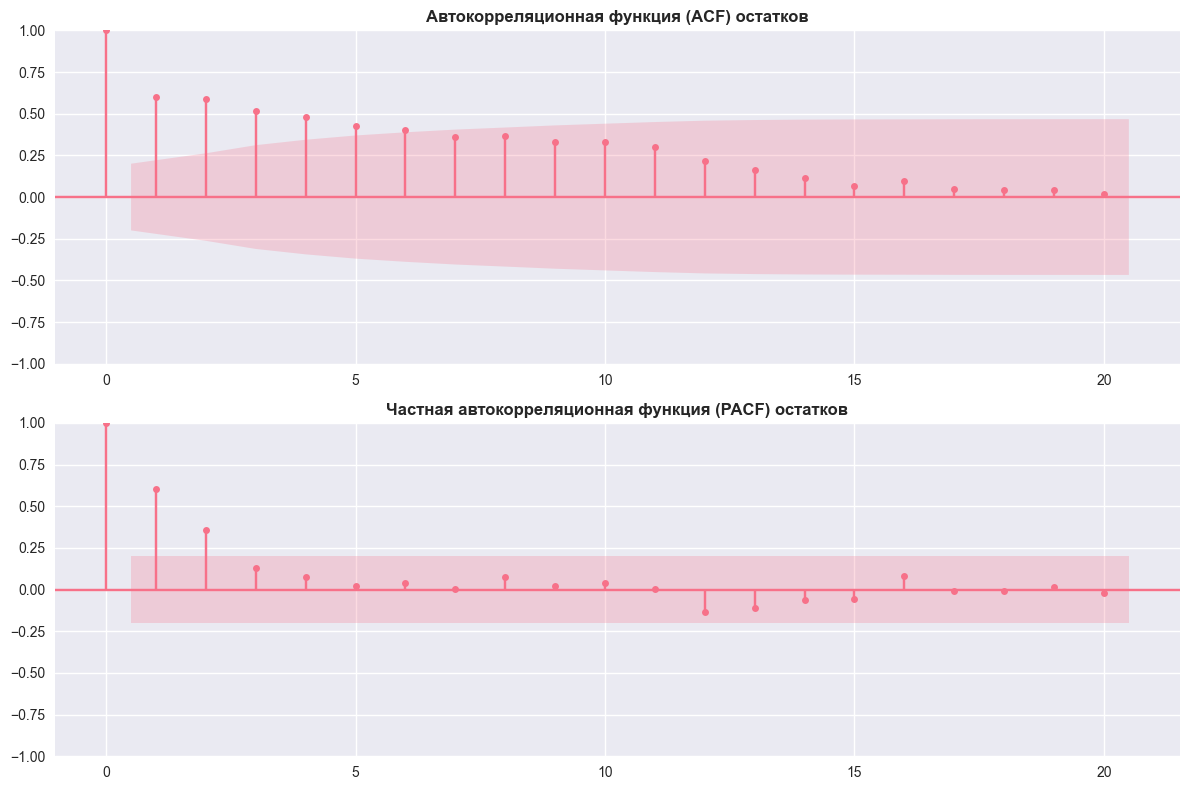


✅ ПРОГНОЗИРОВАНИЕ ЗАВЕРШЕНО! Модель SARIMA учитывает сезонность и тренды.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
import warnings
warnings.filterwarnings('ignore')

# Стиль для красивого графика
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Загрузка данных
df = pd.read_csv('Water_Consumption_city_N.csv', parse_dates=['date'], index_col='date')
ts = df['water_consumption_tonnes']

# Анализ сезонности
def analyze_seasonality(ts):
    print("🔍 АНАЛИЗ СЕЗОННОСТИ ДАННЫХ")
    print("="*50)
    
    # Декомпозиция временного ряда
    decomposition = seasonal_decompose(ts, model='additive', period=12)
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Исходный ряд
    axes[0].plot(ts, label='Исходные данные', color='#2E86AB')
    axes[0].set_title('Исходный временной ряд')
    axes[0].legend()
    
    # Тренд
    axes[1].plot(decomposition.trend, label='Тренд', color='#A23B72')
    axes[1].set_title('Трендовая компонента')
    axes[1].legend()
    
    # Сезонность
    axes[2].plot(decomposition.seasonal, label='Сезонность', color='#F18F01')
    axes[2].set_title('Сезонная компонента')
    axes[2].legend()
    
    # Остатки
    axes[3].plot(decomposition.resid, label='Остатки', color='#C73E1D')
    axes[3].set_title('Остаточная компонента')
    axes[3].legend()
    
    plt.tight_layout()
    plt.show()
    
    return decomposition

decomposition = analyze_seasonality(ts)

# Тест на стационарность
def check_stationarity(ts):
    print("\n📊 ТЕСТ НА СТАЦИОНАРНОСТЬ (Дики-Фуллер)")
    result = adfuller(ts.dropna())
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Критические значения:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.6f}")
    
    if result[1] <= 0.05:
        print("✅ Ряд стационарен (p-value < 0.05)")
        return True
    else:
        print("❌ Ряд нестационарен (p-value > 0.05)")
        return False

is_stationary = check_stationarity(ts)

# Автоматический подбор параметров SARIMA
def find_best_sarima(ts, max_p=3, max_d=2, max_q=3, max_P=1, max_D=1, max_Q=1, seasonal_period=12):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    
    print("\n🔄 ПОДБОР ПАРАМЕТРОВ SARIMA...")
    total_models = (max_p + 1) * (max_d + 1) * (max_q + 1) * (max_P + 1) * (max_D + 1) * (max_Q + 1)
    current_model = 0
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                for P in range(max_P + 1):
                    for D in range(max_D + 1):
                        for Q in range(max_Q + 1):
                            current_model += 1
                            if current_model % 10 == 0:
                                print(f"Проверено {current_model}/{total_models} моделей...")
                            
                            try:
                                model = SARIMAX(ts, 
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, seasonal_period),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
                                model_fit = model.fit(disp=False)
                                
                                if model_fit.aic < best_aic:
                                    best_aic = model_fit.aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, seasonal_period)
                                    print(f"🎯 Новая лучшая модель: SARIMA{best_order}{best_seasonal_order} AIC: {best_aic:.2f}")
                                
                            except:
                                continue
    
    print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ: SARIMA{best_order}{best_seasonal_order} с AIC: {best_aic:.2f}")
    return best_order, best_seasonal_order

# Подбор параметров SARIMA
best_order, best_seasonal_order = find_best_sarima(ts)

# Обучение финальной модели SARIMA
print("\n🎓 ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ SARIMA...")
final_model = SARIMAX(ts, 
                     order=best_order,
                     seasonal_order=best_seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False)

model_fit = final_model.fit(disp=False)

print("✅ Модель успешно обучена!")

# Прогноз на 2024-2025 годы (24 месяца)
forecast_steps = 24
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Создаем даты для прогноза
last_date = ts.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                             periods=forecast_steps, freq='M')

# Визуализация результатов
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14), 
                              gridspec_kw={'height_ratios': [2, 1]})

# Основной график - исторические данные и прогноз
historical_line = ax1.plot(ts.index, ts.values, 
                         label='Исторические данные', 
                         linewidth=3, 
                         color='#2E86AB',
                         marker='o',
                         markersize=4,
                         alpha=0.8,
                         zorder=5)

# Линия прогноза SARIMA
forecast_line = ax1.plot(forecast_dates, forecast.values,
                       label=f'Прогноз SARIMA{best_order}{best_seasonal_order} (2024-2025)', 
                       linewidth=3, 
                       color='#A23B72',
                       linestyle='-',
                       marker='s',
                       markersize=5,
                       alpha=0.9,
                       zorder=4)

# Доверительный интервал
ax1.fill_between(forecast_dates, 
                conf_int.iloc[:, 0], 
                conf_int.iloc[:, 1], 
                color='#A23B72', 
                alpha=0.15, 
                label='95% доверительный интервал',
                zorder=3)

# Вертикальная линия разделения
ax1.axvline(x=last_date, color='red', linestyle=':', alpha=0.7, linewidth=2, zorder=6)
ax1.text(last_date, ax1.get_ylim()[1]*0.9, 'Начало прогноза', 
        rotation=90, verticalalignment='top', fontweight='bold', fontsize=10)

# Разделяем годы разными цветами фона
years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]
colors = ['#F8F9FA', '#E9ECEF', '#F8F9FA', '#E9ECEF', '#F8F9FA', '#FFF3CD', '#FFE5D4']

for i, year in enumerate(years):
    start_date = pd.Timestamp(f'{year}-01-01')
    end_date = pd.Timestamp(f'{year+1}-01-01') if year < 2025 else pd.Timestamp(f'{year}-12-31')
    
    if start_date < forecast_dates[-1]:
        ax1.axvspan(start_date, end_date, alpha=0.15, color=colors[i % len(colors)], zorder=1)
        ax1.text(pd.Timestamp(f'{year}-06-01'), ax1.get_ylim()[0] + 15000, 
                str(year), ha='center', va='bottom', fontweight='bold', alpha=0.8, fontsize=10)

# Настройки основного графика
ax1.set_title(f'📊 Прогноз потребления воды на 2024-2025 годы\nМодель SARIMA{best_order}{best_seasonal_order}', 
             fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Потребление воды (тонны)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3, zorder=1)
ax1.tick_params(axis='x', rotation=45)

# Аннотации для ключевых точек
max_hist = ts.idxmax()
ax1.annotate(f'Исторический макс: {ts.max():,.0f}т', 
           xy=(max_hist, ts.max()), 
           xytext=(max_hist, ts.max() + 15000),
           arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
           fontweight='bold',
           ha='center',
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Аннотации для прогноза
max_forecast_idx = np.argmax(forecast.values)
max_forecast_date = forecast_dates[max_forecast_idx]
ax1.annotate(f'Прогноз макс: {forecast.values[max_forecast_idx]:,.0f}т', 
           xy=(max_forecast_date, forecast.values[max_forecast_idx]), 
           xytext=(max_forecast_date, forecast.values[max_forecast_idx] + 15000),
           arrowprops=dict(arrowstyle='->', color='#A23B72', alpha=0.7),
           fontweight='bold',
           ha='center',
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

min_forecast_idx = np.argmin(forecast.values)
min_forecast_date = forecast_dates[min_forecast_idx]
ax1.annotate(f'Прогноз мин: {forecast.values[min_forecast_idx]:,.0f}т', 
           xy=(min_forecast_date, forecast.values[min_forecast_idx]), 
           xytext=(min_forecast_date, forecast.values[min_forecast_idx] - 20000),
           arrowprops=dict(arrowstyle='->', color='#A23B72', alpha=0.7),
           fontweight='bold',
           ha='center',
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# График остатков
residuals = model_fit.resid
ax2.plot(residuals.index, residuals.values, 
        color='#6C757D', 
        linewidth=1.5,
        alpha=0.8)
ax2.axhline(y=0, color='red', linestyle='-', alpha=0.5)
ax2.fill_between(residuals.index, residuals.values, 0, 
                where=(residuals.values >= 0), 
                color='green', alpha=0.3, interpolate=True)
ax2.fill_between(residuals.index, residuals.values, 0, 
                where=(residuals.values < 0), 
                color='red', alpha=0.3, interpolate=True)

ax2.set_title('Остатки модели SARIMA', fontsize=14, fontweight='bold')
ax2.set_ylabel('Остатки', fontsize=12, fontweight='bold')
ax2.set_xlabel('Дата', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Детальная таблица прогноза
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'year': forecast_dates.year,
    'month': forecast_dates.month,
    'water_consumption_tonnes_forecast': forecast.values,
    'confidence_lower': conf_int.iloc[:, 0],
    'confidence_upper': conf_int.iloc[:, 1]
})

# Словарь для перевода месяцев
month_names_ru = {
    1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 
    5: 'Май', 6: 'Июнь', 7: 'Июль', 8: 'Август', 
    9: 'Сентябрь', 10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'
}

# Вывод детальной информации
print("="*80)
print("🎯 ДЕТАЛЬНЫЙ ПРОГНОЗ ПОТРЕБЛЕНИЯ ВОДЫ НА 2024-2025 ГОДЫ (SARIMA)")
print("="*80)
print(f"📈 Модель: SARIMA{best_order}{best_seasonal_order}")
print("💡 ДИ - доверительный интервал (95% вероятность)")

# Прогноз по годам
for year in [2024, 2025]:
    year_data = forecast_df[forecast_df['year'] == year]
    print(f"\n📅 {year} ГОД:")
    print(" " * 70)  # Заменили черточки на пробелы
    for _, row in year_data.iterrows():
        month_name = month_names_ru[row['month']]
        
        # Форматирование чисел без запятых (заменяем запятые на пробелы)
        forecast_val = f"{row['water_consumption_tonnes_forecast']:,.0f}".replace(',', ' ')
        conf_lower = f"{row['confidence_lower']:,.0f}".replace(',', ' ')
        conf_upper = f"{row['confidence_upper']:,.0f}".replace(',', ' ')
        
        print(f"  {month_name:12} {forecast_val:>8} т "
              f"(ДИ: {conf_lower:>8} - {conf_upper:>8})")
    
    year_avg = year_data['water_consumption_tonnes_forecast'].mean()
    year_total = year_data['water_consumption_tonnes_forecast'].sum()
    year_avg_formatted = f"{year_avg:,.0f}".replace(',', ' ')
    year_total_formatted = f"{year_total:,.0f}".replace(',', ' ')
    print(f"  {'Среднее:':12} {year_avg_formatted:>8} т/мес")
    print(f"  {'Всего за год:':12} {year_total_formatted:>8} т")

# Статистика модели
print("\n" + "="*80)
print("📈 СТАТИСТИКА МОДЕЛИ SARIMA")
print("="*80)
print(f"Параметры модели: SARIMA{best_order}{best_seasonal_order}")
print(f"AIC: {model_fit.aic:.2f}")
print(f"BIC: {model_fit.bic:.2f}")
print(f"HQIC: {model_fit.hqic:.2f}")
print(f"Средняя ошибка: {abs(residuals).mean():,.0f} т".replace(',', ' '))
print(f"Точность модели: {1 - (abs(residuals).mean() / ts.mean()):.2%}")

# Диагностика модели - ИСПРАВЛЕННЫЙ БЛОК
print(f"\n🔍 ДИАГНОСТИКА МОДЕЛИ:")
print(f"• Стандартное отклонение остатков: {residuals.std():,.0f} т".replace(',', ' '))

# ИСПРАВЛЕННЫЙ тест нормальности (Jarque-Bera) - функция возвращает только 2 значения
jb_stat, jb_pvalue = jarque_bera(residuals.dropna())
print(f"• Нормальность остатков (тест Харке-Бера): p-value = {jb_pvalue:.4f}")

# Исправленный тест автокорреляции (Ljung-Box)
lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
lb_pvalue = lb_test['lb_pvalue'].iloc[0]
print(f"• Автокорреляция остатков (тест Льюнга-Бокса): p-value = {lb_pvalue:.4f}")

# Анализ сезонных паттернов
print(f"\n🌡️  СЕЗОННЫЕ ПАТТЕРНЫ (на основе SARIMA):")
seasonal_component = decomposition.seasonal
monthly_avg = seasonal_component.groupby(seasonal_component.index.month).mean()

high_season_months = []
low_season_months = []
medium_season_months = []

for month in range(1, 13):
    month_name = month_names_ru[month]
    seasonal_effect = monthly_avg[month] + ts.mean()
    relative_effect = seasonal_effect / ts.mean()
    
    if relative_effect > 1.05:
        high_season_months.append(month_name)
        indicator = f"(пик +{((relative_effect-1)*100):.0f}%)"
    elif relative_effect < 0.95:
        low_season_months.append(month_name)
        indicator = f"(спад -{((1-relative_effect)*100):.0f}%)"
    else:
        medium_season_months.append(month_name)
        indicator = f"(норма ±{((1-relative_effect)*100):.0f}%)"
    
    seasonal_effect_formatted = f"{seasonal_effect:,.0f}".replace(',', ' ')
    print(f"  {month_name:12}: {seasonal_effect_formatted:>8} т {indicator}")

# Сравнение с предыдущим годом
print(f"\n📊 СРАВНЕНИЕ С ИСТОРИЧЕСКИМИ ДАННЫМИ:")
historical_2023 = ts[ts.index.year == 2023].mean()
forecast_2024_avg = forecast_df[forecast_df['year'] == 2024]['water_consumption_tonnes_forecast'].mean()
forecast_2025_avg = forecast_df[forecast_df['year'] == 2025]['water_consumption_tonnes_forecast'].mean()

trend_2023_to_2024 = ((forecast_2024_avg - historical_2023) / historical_2023) * 100
trend_2024_to_2025 = ((forecast_2025_avg - forecast_2024_avg) / forecast_2024_avg) * 100

print(f"2023 (факт) → 2024 (прогноз): {trend_2023_to_2024:+.1f}%")
print(f"2024 → 2025: {trend_2024_to_2025:+.1f}%")
print(f"Общий тренд 2023 → 2025: {((forecast_2025_avg - historical_2023) / historical_2023) * 100:+.1f}%")

# Ключевые метрики прогноза
print(f"\n📋 КЛЮЧЕВЫЕ МЕТРИКИ ПРОГНОЗА:")
max_forecast_formatted = f"{forecast.values[max_forecast_idx]:,.0f}".replace(',', ' ')
min_forecast_formatted = f"{forecast.values[min_forecast_idx]:,.0f}".replace(',', ' ')
forecast_2024_avg_formatted = f"{forecast_2024_avg:,.0f}".replace(',', ' ')
forecast_2025_avg_formatted = f"{forecast_2025_avg:,.0f}".replace(',', ' ')
amplitude_formatted = f"{(forecast.max() - forecast.min()):,.0f}".replace(',', ' ')

print(f"• Максимальное потребление: {max_forecast_formatted} т ({max_forecast_date.strftime('%B %Y')})")
print(f"• Минимальное потребление: {min_forecast_formatted} т ({min_forecast_date.strftime('%B %Y')})")
print(f"• Среднегодовое 2024: {forecast_2024_avg_formatted} т/мес")
print(f"• Среднегодовое 2025: {forecast_2025_avg_formatted} т/мес")
print(f"• Амплитуда колебаний: {amplitude_formatted} т")
print(f"• Коэффициент сезонности: {(forecast.max() / forecast.min()):.2f}x")

# Рекомендации на основе SARIMA
print(f"\n💎 РЕКОМЕНДАЦИИ НА ОСНОВЕ SARIMA МОДЕЛИ:")
if trend_2023_to_2024 > 2:
    print(f"• 🔥 КРИТИЧЕСКИЙ РОСТ: Подготовиться к значительному увеличению потребления на {trend_2023_to_2024:+.1f}%")
elif trend_2023_to_2024 > 0:
    print(f"• 📈 УМЕРЕННЫЙ РОСТ: Ожидается рост потребления на {trend_2023_to_2024:+.1f}%")
elif trend_2023_to_2024 > -2:
    print(f"• ⚖️  СТАБИЛЬНОСТЬ: Потребление останется на прежнем уровне ({trend_2023_to_2024:+.1f}%)")
else:
    print(f"• 📉 СНИЖЕНИЕ: Ожидается снижение потребления на {abs(trend_2023_to_2024):.1f}%")

print(f"• 🎯 ПЛАНИРОВАНИЕ: Учесть сезонные пики в {max_forecast_date.strftime('%B')}")
print(f"• 💧 ИНФРАСТРУКТУРА: Оптимизировать под диапазон {forecast.min():,.0f} - {forecast.max():,.0f} т/мес".replace(',', ' '))
print(f"• 📅 РЕСУРСЫ: Запланировать дополнительные мощности на высокий сезон ({', '.join(high_season_months)})")

# Дополнительная диагностика - график автокорреляции
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF остатков
plot_acf(residuals.dropna(), ax=ax1, lags=20, alpha=0.05)
ax1.set_title('Автокорреляционная функция (ACF) остатков', fontweight='bold')

# PACF остатков
plot_pacf(residuals.dropna(), ax=ax2, lags=20, alpha=0.05)
ax2.set_title('Частная автокорреляционная функция (PACF) остатков', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✅ ПРОГНОЗИРОВАНИЕ ЗАВЕРШЕНО! Модель SARIMA учитывает сезонность и тренды.")
print("="*80)

CATBOOST

Загрузка данных...
Создание признаков...
Разделение данных...
Размер обучающей выборки: (91, 27)
Размер тестовой выборки: (5, 27)
Обучение модели CatBoost...
0:	learn: 25855.2618851	test: 20897.2337975	best: 20897.2337975 (0)	total: 169ms	remaining: 2m 48s
100:	learn: 1291.4591454	test: 7015.7925337	best: 7015.7925337 (100)	total: 13.9s	remaining: 2m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6778.593734
bestIteration = 141

Shrink model to first 142 iterations.

Оценка модели на тестовых данных...
MAE на тестовых данных: 5505.95
RMSE на тестовых данных: 6778.59

Создание датасета для прогноза 2024-2025...
Заполнение погодных данных...
Заполнение других признаков...
Прогнозирование потребления воды на 2024-2025...

Создание графиков...


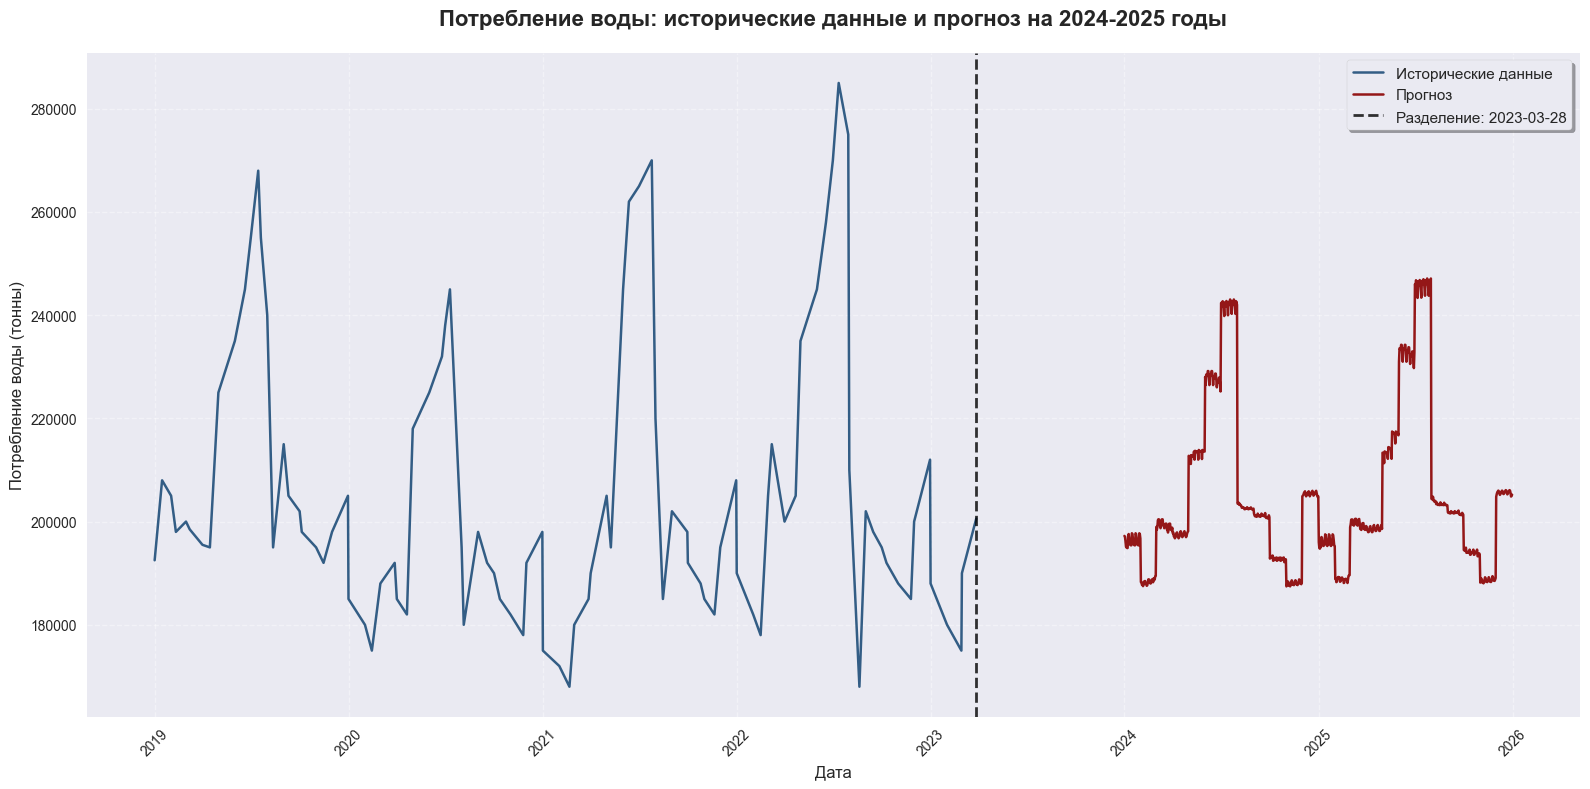

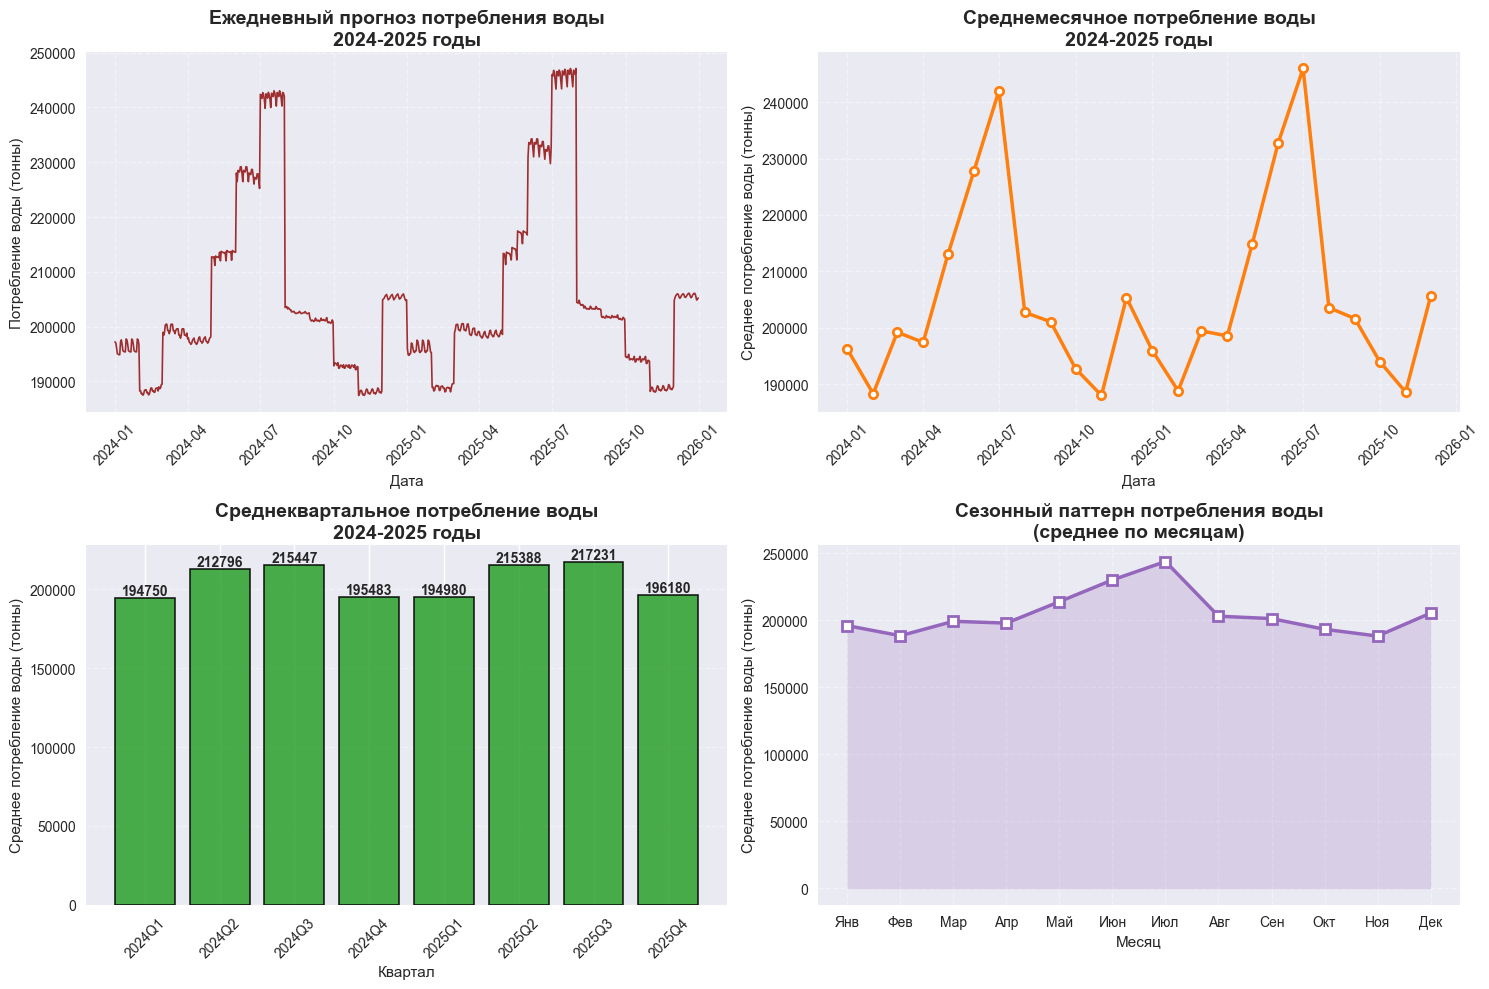

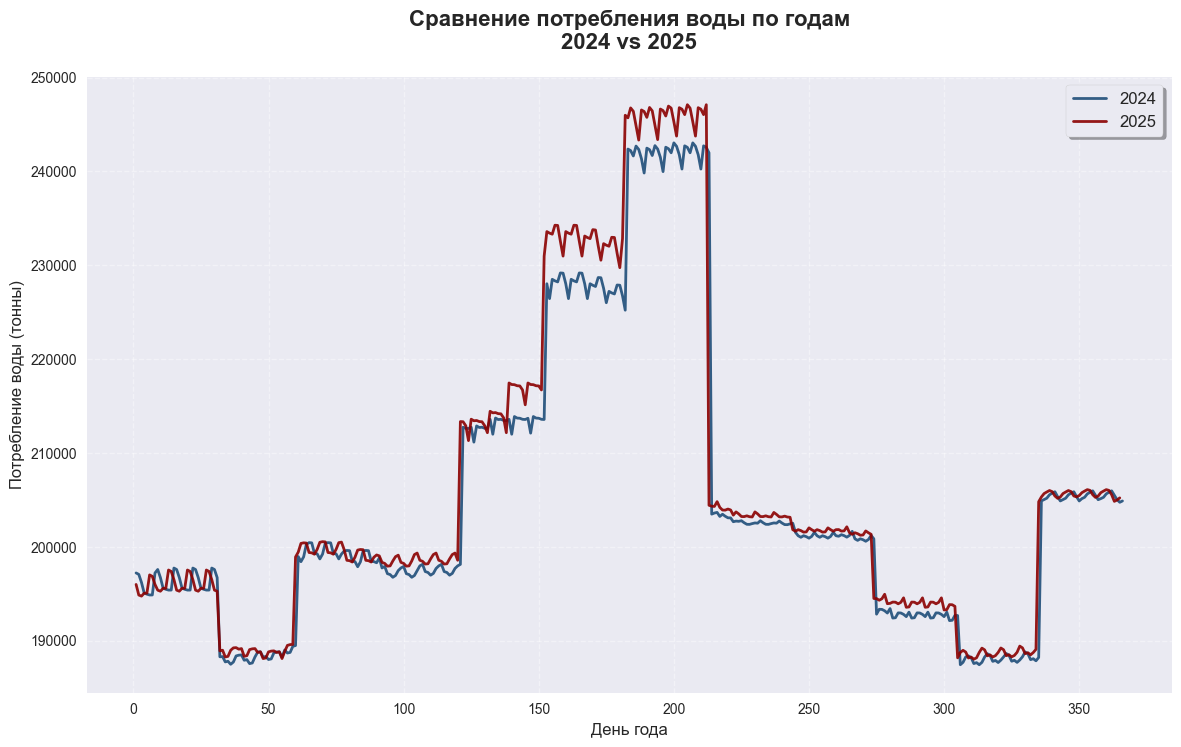

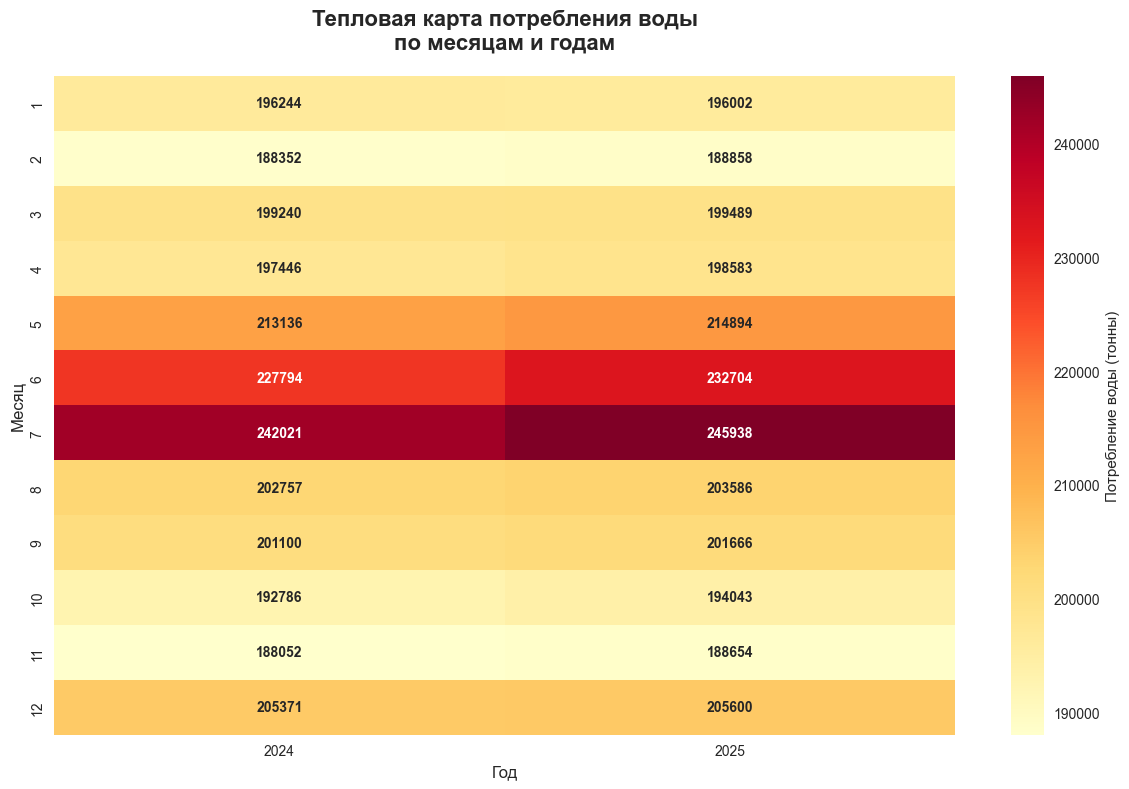

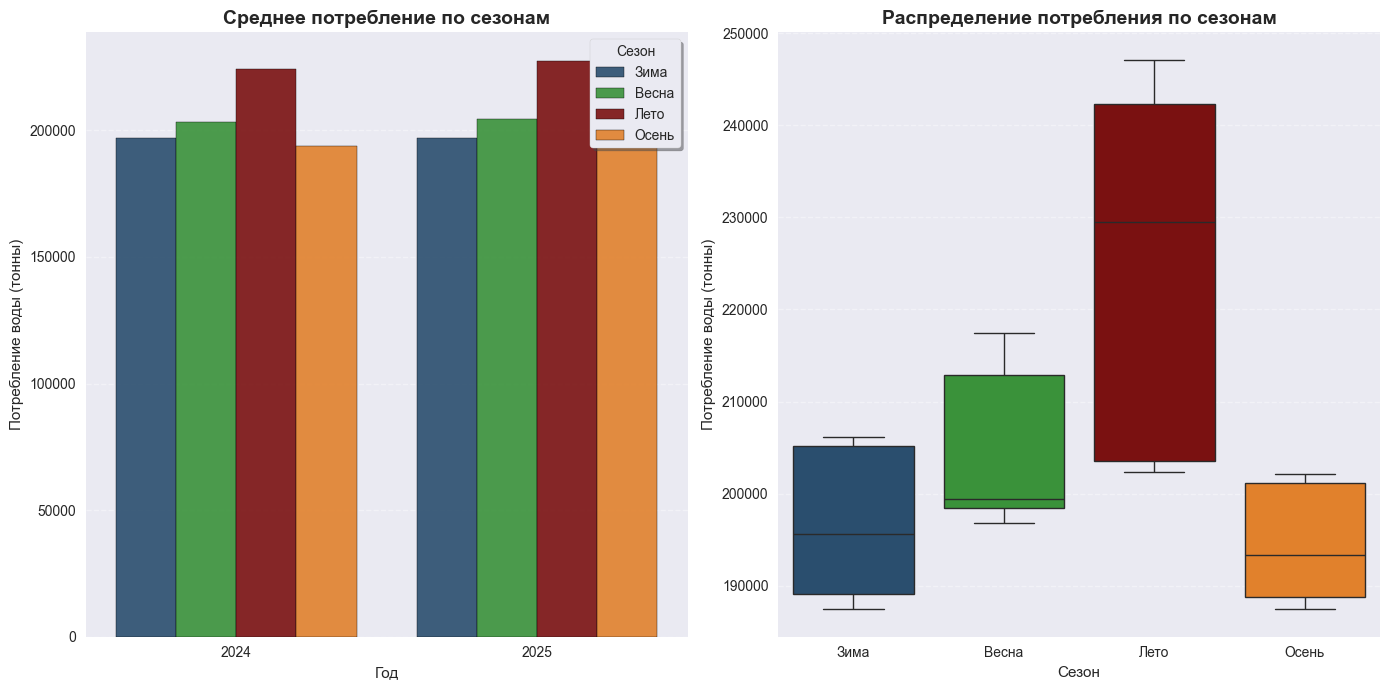


Статистика прогнозов по годам:
           mean       std        min        max     median
year                                                      
2024  204623.39  15459.36  187442.45  243041.12  200643.40
2025  205978.87  16744.61  188034.00  247106.40  201265.06

Статистика прогнозов по сезонам:
             mean       std        min        max     median
season                                                      
Весна   203860.74   7370.26  196757.35  217460.00  199361.37
Зима    196960.93   6918.10  187488.02  206099.09  195595.21
Лето    225751.62  17206.03  202363.45  247106.40  229463.57
Осень   194372.78   5377.29  187442.45  202135.43  193342.42

Результаты сохранены в файл: water_consumption_forecast_2024_2025.csv

Топ-10 самых важных признаков:
                 feature  importance
14              uv_index   22.259391
8             wind_speed   11.722733
19       reservoir_level    9.547405
11         tourism_index    8.694351
7               humidity    8.515716
17     

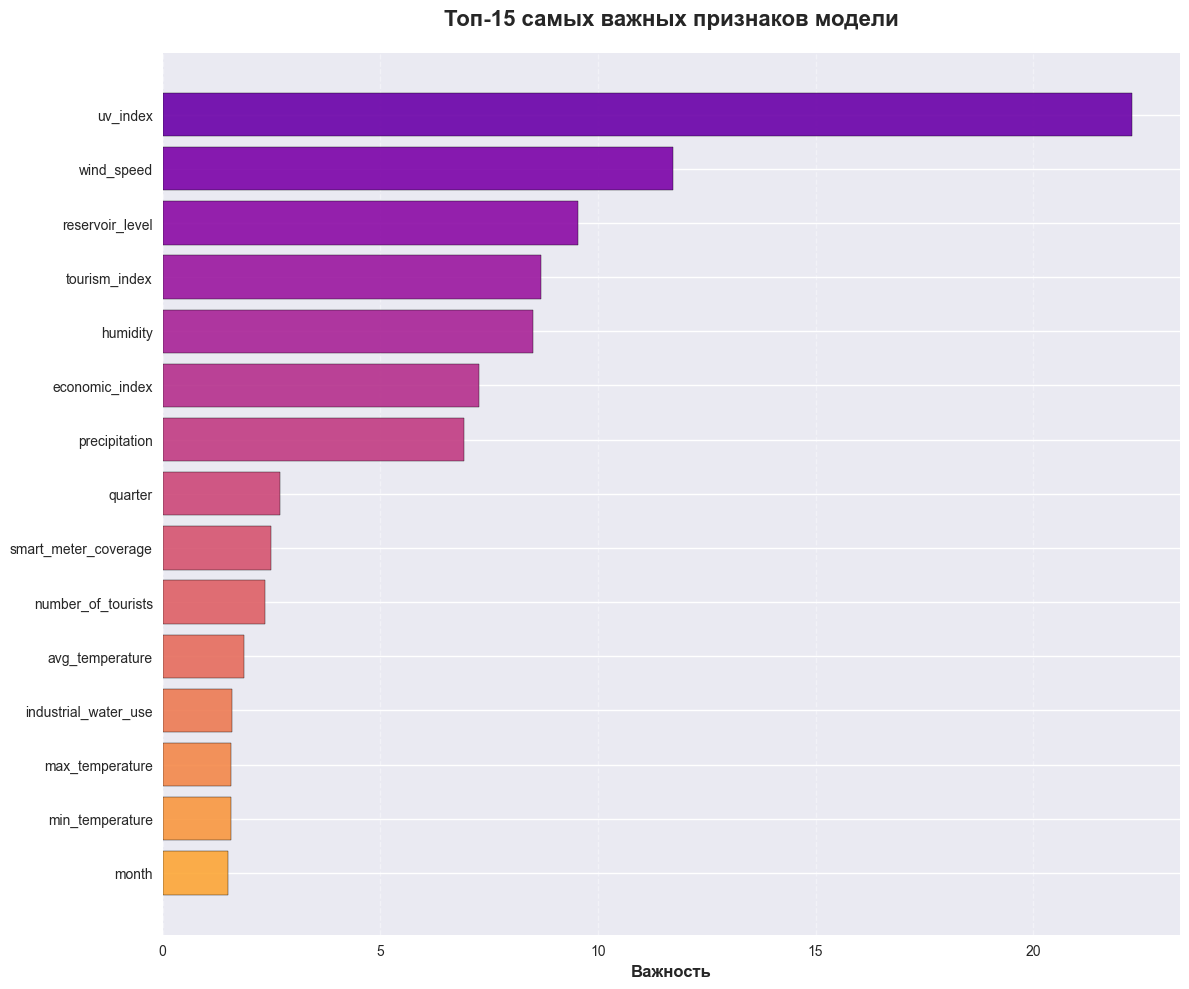


Прогнозирование завершено!
Среднее прогнозируемое потребление: 205300 тонн в день
Максимальное потребление: 247106 тонн
Минимальное потребление: 187442 тонн


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8')

# Загрузка данных
print("Загрузка данных...")
data = pd.read_csv('Water_Consumption_city_N.csv')
data['date'] = pd.to_datetime(data['date'])

# Сохраняем оригинальные данные для визуализации
original_data = data[['date', 'water_consumption_tonnes']].copy()

# Создание новых признаков
print("Создание признаков...")
data['quarter'] = data['date'].dt.quarter
data['day_of_year'] = data['date'].dt.dayofyear
data['week_of_year'] = data['date'].dt.isocalendar().week

# Кодирование дня недели
day_of_week_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
data['day_of_week_encoded'] = data['day_of_week'].map(day_of_week_map)

# Удаление старых признаков (НЕ УДАЛЯЕМ month - он нужен для группировки)
columns_to_drop = ['date', 'year', 'day', 'day_of_week']
data = data.drop(columns_to_drop, axis=1)

# Определение категориальных признаков
categorical_features = ['is_weekend', 'is_holiday', 'pool_opening_season', 'garden_watering_season', 'quarter']

# Разделение на обучающую и тестовую выборки
print("Разделение данных...")
# Находим индекс начала 2023 года
data_2023_start = data[data['day_of_year'] == 1].index[-1]
train_data = data[data.index < data_2023_start].copy()
test_data = data[data.index >= data_2023_start].copy()

X_train = train_data.drop('water_consumption_tonnes', axis=1)
y_train = train_data['water_consumption_tonnes']
X_test = test_data.drop('water_consumption_tonnes', axis=1)
y_test = test_data['water_consumption_tonnes']

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

# Обучение модели CatBoost
print("Обучение модели CatBoost...")
model = CatBoostRegressor(
    cat_features=categorical_features,
    random_seed=42,
    depth=8,
    learning_rate=0.1,
    iterations=1000,
    early_stopping_rounds=50,
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Оценка модели на тестовых данных
print("\nОценка модели на тестовых данных...")
test_predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"MAE на тестовых данных: {mae:.2f}")
print(f"RMSE на тестовых данных: {rmse:.2f}")

# Создание датасета для прогноза на 2024-2025
print("\nСоздание датасета для прогноза 2024-2025...")
future_dates = pd.date_range(start='2024-01-01', end='2025-12-31', freq='D')
future_data = pd.DataFrame({'date': future_dates})

# Заполнение базовых признаков
future_data['year'] = future_data['date'].dt.year
future_data['month'] = future_data['date'].dt.month
future_data['day'] = future_data['date'].dt.day
future_data['day_of_week'] = future_data['date'].dt.day_name()
future_data['is_weekend'] = (future_data['day_of_week'].isin(['Saturday', 'Sunday'])).astype(int)
future_data['quarter'] = future_data['date'].dt.quarter
future_data['day_of_year'] = future_data['date'].dt.dayofyear
future_data['week_of_year'] = future_data['date'].dt.isocalendar().week

# Кодирование дня недели
future_data['day_of_week_encoded'] = future_data['day_of_week'].map(day_of_week_map)

# Заполнение праздников
future_data['is_holiday'] = 0
future_data.loc[(future_data['month'] == 1) & (future_data['day'] <= 8), 'is_holiday'] = 1
future_data.loc[(future_data['month'] == 5) & (future_data['day'] <= 10), 'is_holiday'] = 1

# Заполнение погодных данных (используем месяц для группировки)
print("Заполнение погодных данных...")
weather_features = ['avg_temperature', 'min_temperature', 'max_temperature', 
                   'precipitation', 'humidity', 'wind_speed', 'uv_index']

# Группируем по месяцу из исходных данных
monthly_weather_means = data.groupby('month')[weather_features].mean()

for feature in weather_features:
    monthly_means_dict = monthly_weather_means[feature].to_dict()
    future_data[feature] = future_data['month'].map(monthly_means_dict)

# Заполнение других признаков
print("Заполнение других признаков...")

# Население - линейный рост
base_population = data['population'].iloc[-1]
future_data['population'] = base_population * (1 + 0.005) ** (future_data['year'] - 2023)

# Цена воды - небольшой рост
base_water_price = data['water_price'].iloc[-1]
future_data['water_price'] = base_water_price * (1 + 0.02) ** (future_data['year'] - 2023)

# Туризм - сезонные паттерны + небольшой рост
base_tourism = data.groupby('month')['tourism_index'].mean()
future_data['tourism_index'] = future_data['month'].map(base_tourism.to_dict()) * \
                             (1 + 0.03) ** (future_data['year'] - 2023)

# Промышленное использование воды
base_industrial = data.groupby('month')['industrial_water_use'].mean()
future_data['industrial_water_use'] = future_data['month'].map(base_industrial.to_dict())

# Ограничения воды - 0 по умолчанию
future_data['water_restrictions'] = 0

# Количество туристов
base_tourists = data.groupby('month')['number_of_tourists'].mean()
future_data['number_of_tourists'] = future_data['month'].map(base_tourists.to_dict()) * \
                                  (1 + 0.03) ** (future_data['year'] - 2023)

# Экономические индексы - умеренный рост
base_construction = data['construction_index'].iloc[-1]
base_economic = data['economic_index'].iloc[-1]
future_data['construction_index'] = base_construction * (1 + 0.015) ** (future_data['year'] - 2023)
future_data['economic_index'] = base_economic * (1 + 0.025) ** (future_data['year'] - 2023)

# Аварии водопровода - средние значения
future_data['water_main_breaks'] = data['water_main_breaks'].mean()

# Уровень резервуара - средние значения
future_data['reservoir_level'] = data['reservoir_level'].mean()

# Сезонные признаки (бассейны и полив)
future_data['pool_opening_season'] = ((future_data['month'] >= 5) & (future_data['month'] <= 9)).astype(int)
future_data['garden_watering_season'] = ((future_data['month'] >= 4) & (future_data['month'] <= 10)).astype(int)

# Покрытие умными счетчиками - рост
base_smart_meter = data['smart_meter_coverage'].iloc[-1]
future_data['smart_meter_coverage'] = base_smart_meter * (1 + 0.1) ** (future_data['year'] - 2023)

# Удаление временных столбцов (НЕ УДАЛЯЕМ month - он нужен для модели)
columns_to_drop_future = ['date', 'day', 'day_of_week']
future_features = future_data.drop(columns_to_drop_future, axis=1)

# Убедимся, что порядок столбцов совпадает с обучающими данными
future_features = future_features[X_train.columns]

# Прогнозирование
print("Прогнозирование потребления воды на 2024-2025...")
future_predictions = model.predict(future_features)

# Создание финального датафрейма с результатами
results = pd.DataFrame({
    'date': future_dates,
    'predicted_water_consumption_tonnes': future_predictions
})

# Добавление месяца и года для агрегации
results['year'] = results['date'].dt.year
results['month'] = results['date'].dt.month
results['quarter'] = results['date'].dt.quarter

# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

print("\nСоздание графиков...")

# Определение контрастной цветовой палитры
colors = {
    'blue': '#1f77b4',
    'orange': '#ff7f0e',
    'red': '#d62728',
    'green': '#2ca02c',
    'purple': '#9467bd',
    'brown': '#8c564b',
    'pink': '#e377c2',
    'gray': '#7f7f7f',
    'yellow': '#bcbd22',
    'cyan': '#17becf',
    'dark_blue': '#1f4e79',
    'dark_red': '#8B0000',
    'dark_green': '#006400'
}

# 1. ОБЪЕДИНЕННЫЙ ГРАФИК: исторические данные + прогноз
plt.figure(figsize=(16, 8))

# Построение графика
plt.plot(original_data['date'], original_data['water_consumption_tonnes'], 
         label='Исторические данные', color=colors['dark_blue'], alpha=0.9, linewidth=1.8)
plt.plot(results['date'], results['predicted_water_consumption_tonnes'], 
         label='Прогноз', color=colors['dark_red'], alpha=0.9, linewidth=1.8)

# Добавляем вертикальную линию разделения
split_date = original_data['date'].max()
plt.axvline(x=split_date, color='black', linestyle='--', alpha=0.8, 
           label=f'Разделение: {split_date.strftime("%Y-%m-%d")}', linewidth=2)

plt.title('Потребление воды: исторические данные и прогноз на 2024-2025 годы', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Потребление воды (тонны)', fontsize=12)
plt.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.4, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Общий график прогноза на 2024-2025
plt.figure(figsize=(15, 10))

# Ежедневные прогнозы
plt.subplot(2, 2, 1)
plt.plot(results['date'], results['predicted_water_consumption_tonnes'], 
        alpha=0.8, linewidth=1.2, color=colors['dark_red'])
plt.title('Ежедневный прогноз потребления воды\n2024-2025 годы', fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=11)
plt.ylabel('Потребление воды (тонны)', fontsize=11)
plt.grid(True, alpha=0.4, linestyle='--')
plt.xticks(rotation=45)

# Месячные агрегаты
plt.subplot(2, 2, 2)
monthly_agg = results.groupby(['year', 'month'])['predicted_water_consumption_tonnes'].mean().reset_index()
monthly_agg['date'] = pd.to_datetime(monthly_agg['year'].astype(str) + '-' + monthly_agg['month'].astype(str) + '-01')

plt.plot(monthly_agg['date'], monthly_agg['predicted_water_consumption_tonnes'], 
        marker='o', linewidth=2.5, color=colors['orange'], markersize=6, markerfacecolor='white', markeredgewidth=2)
plt.title('Среднемесячное потребление воды\n2024-2025 годы', fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=11)
plt.ylabel('Среднее потребление воды (тонны)', fontsize=11)
plt.grid(True, alpha=0.4, linestyle='--')
plt.xticks(rotation=45)

# Квартальные агрегаты
plt.subplot(2, 2, 3)
quarterly_agg = results.groupby(['year', 'quarter'])['predicted_water_consumption_tonnes'].mean().reset_index()
quarterly_agg['period'] = quarterly_agg['year'].astype(str) + 'Q' + quarterly_agg['quarter'].astype(str)

bars = plt.bar(quarterly_agg['period'], quarterly_agg['predicted_water_consumption_tonnes'], 
       color=colors['green'], alpha=0.85, edgecolor='black', linewidth=1.2)
plt.title('Среднеквартальное потребление воды\n2024-2025 годы', fontsize=14, fontweight='bold')
plt.xlabel('Квартал', fontsize=11)
plt.ylabel('Среднее потребление воды (тонны)', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.4, linestyle='--', axis='y')

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

# Сезонные паттерны по месяцам
plt.subplot(2, 2, 4)
seasonal_pattern = results.groupby('month')['predicted_water_consumption_tonnes'].mean()
months = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

plt.plot(months, seasonal_pattern.values, marker='s', linewidth=2.5, color=colors['purple'], 
         markersize=7, markerfacecolor='white', markeredgewidth=2)
plt.fill_between(months, seasonal_pattern.values, alpha=0.2, color=colors['purple'])
plt.title('Сезонный паттерн потребления воды\n(среднее по месяцам)', fontsize=14, fontweight='bold')
plt.xlabel('Месяц', fontsize=11)
plt.ylabel('Среднее потребление воды (тонны)', fontsize=11)
plt.grid(True, alpha=0.4, linestyle='--')

plt.tight_layout()
plt.show()

# 3. Сравнение по годам
plt.figure(figsize=(14, 8))

# Годовое сравнение
yearly_data = []
for year in [2024, 2025]:
    year_data = results[results['year'] == year].copy()
    year_data['day_of_year'] = year_data['date'].dt.dayofyear
    yearly_data.append(year_data)

plt.plot(yearly_data[0]['day_of_year'], yearly_data[0]['predicted_water_consumption_tonnes'], 
         label='2024', linewidth=2, alpha=0.9, color=colors['dark_blue'])
plt.plot(yearly_data[1]['day_of_year'], yearly_data[1]['predicted_water_consumption_tonnes'], 
         label='2025', linewidth=2, alpha=0.9, color=colors['dark_red'])

plt.title('Сравнение потребления воды по годам\n2024 vs 2025', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('День года', fontsize=12)
plt.ylabel('Потребление воды (тонны)', fontsize=12)
plt.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.4, linestyle='--')
plt.show()

# 4. Тепловая карта потребления по месяцам и годам
plt.figure(figsize=(12, 8))
heatmap_data = results.pivot_table(values='predicted_water_consumption_tonnes', 
                                 index='month', columns='year', aggfunc='mean')

sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', 
           cbar_kws={'label': 'Потребление воды (тонны)'},
           annot_kws={'size': 10, 'weight': 'bold'})
plt.title('Тепловая карта потребления воды\nпо месяцам и годам', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Месяц', fontsize=12)
plt.tight_layout()
plt.show()

# 5. Распределение потребления по сезонам
plt.figure(figsize=(14, 7))

# Определение сезонов
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    else:
        return 'Осень'

results['season'] = results['month'].apply(get_season)
seasonal_agg = results.groupby(['year', 'season'])['predicted_water_consumption_tonnes'].mean().reset_index()

# Упорядочивание сезонов
season_order = ['Зима', 'Весна', 'Лето', 'Осень']
seasonal_agg['season'] = pd.Categorical(seasonal_agg['season'], categories=season_order, ordered=True)
seasonal_agg = seasonal_agg.sort_values(['year', 'season'])

# Контрастные цвета для сезонов
season_colors = [colors['dark_blue'], colors['green'], colors['dark_red'], colors['orange']]

# Столбчатая диаграмма по сезонам
plt.subplot(1, 2, 1)
sns.barplot(data=seasonal_agg, x='year', y='predicted_water_consumption_tonnes', 
            hue='season', palette=season_colors, edgecolor='black', alpha=0.9)
plt.title('Среднее потребление по сезонам', fontsize=14, fontweight='bold')
plt.xlabel('Год', fontsize=11)
plt.ylabel('Потребление воды (тонны)', fontsize=11)
plt.legend(title='Сезон', frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.4, linestyle='--', axis='y')

# Ящик с усами по сезонам
plt.subplot(1, 2, 2)
sns.boxplot(data=results, x='season', y='predicted_water_consumption_tonnes', 
            order=season_order, palette=season_colors)
plt.title('Распределение потребления по сезонам', fontsize=14, fontweight='bold')
plt.xlabel('Сезон', fontsize=11)
plt.ylabel('Потребление воды (тонны)', fontsize=11)
plt.grid(True, alpha=0.4, linestyle='--', axis='y')

plt.tight_layout()
plt.show()

# Статистика по годам
print("\nСтатистика прогнозов по годам:")
yearly_stats = results.groupby('year')['predicted_water_consumption_tonnes'].agg([
    'mean', 'std', 'min', 'max', 'median'
]).round(2)
print(yearly_stats)

# Статистика по сезонам
print("\nСтатистика прогнозов по сезонам:")
seasonal_stats = results.groupby('season')['predicted_water_consumption_tonnes'].agg([
    'mean', 'std', 'min', 'max', 'median'
]).round(2)
print(seasonal_stats)

# Сохранение результатов
results.to_csv('water_consumption_forecast_2024_2025.csv', index=False)
print("\nРезультаты сохранены в файл: water_consumption_forecast_2024_2025.csv")

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-10 самых важных признаков:")
print(feature_importance.head(10))

# Визуализация важности признаков
plt.figure(figsize=(12, 10))
top_features = feature_importance.head(15)

# Создаем контрастную цветовую карту
colors_importance = plt.cm.plasma(np.linspace(0.2, 0.8, len(top_features)))

plt.barh(top_features['feature'], top_features['importance'], 
         color=colors_importance, edgecolor='black', alpha=0.9)
plt.xlabel('Важность', fontsize=12, fontweight='bold')
plt.title('Топ-15 самых важных признаков модели', fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.4, linestyle='--', axis='x')
plt.tight_layout()
plt.show()

print("\nПрогнозирование завершено!")
print(f"Среднее прогнозируемое потребление: {results['predicted_water_consumption_tonnes'].mean():.0f} тонн в день")
print(f"Максимальное потребление: {results['predicted_water_consumption_tonnes'].max():.0f} тонн")
print(f"Минимальное потребление: {results['predicted_water_consumption_tonnes'].min():.0f} тонн")